In [1]:
%load_ext autoreload 
%autoreload 2

import yaml
import json
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import DataLoader, ConcatDataset
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torchaudio
import pandas as pd
from torch.utils.data import Dataset
from IPython.display import Audio
import librosa
from typing import Tuple

from fusanet_utils.datasets.simulated import SimulatedPoliphonic
from fusanet_utils.datasets.fusa import FUSA_dataset
from fusanet_utils.transforms import Collate_and_transform

scenarios = {0:'square', 1:'park', 2:'waterfront', 3:'market', 4:'street'}
is_scenario = lambda filename: [key for key, scene in scenarios.items() if scene in filename][0]
    
preds_soft, labels, distances, places, names = [], [], [], [], []
experiment_path = Path('../../experiments/Poliphonic-PANN-sed-no-pretrained/')
print(experiment_path)
categories = json.load(open(str(experiment_path / 'index_to_name.json')))
model = torch.load(str(experiment_path / 'model.pt'))
model.eval()
params = yaml.safe_load(open(str(experiment_path / 'params.yaml')))

../../experiments/Poliphonic-PANN-sed-no-pretrained


In [2]:
df_labeled = []
make_name = lambda x : x.split('.')[0].split('-')[1]
for file in sorted(Path('ETIQUETASFuSA').rglob('*.json')):
    #print(file)
    df = pd.read_json(file)
    df["name"] = df["file_upload"].apply(make_name)
    #display(df["file_upload"].head(5))
    #df_labeled.append(df[["name", "annotations"]].set_index("name"))
    df_labeled.append(df[["name", "annotations"]])
df_labeled = pd.concat(df_labeled, axis=0)
df_labeled.head(5)

,name,annotations
0,1655116900_1655116960,"[{'id': 67, 'completed_by': 1, 'result': [{'or..."
1,1654909819_1654909879,"[{'id': 57, 'completed_by': 1, 'result': [{'or..."
2,1654998169_1654998229,"[{'id': 62, 'completed_by': 1, 'result': [{'or..."
3,1654998838_1654998898,"[{'id': 63, 'completed_by': 1, 'result': [{'or..."
4,1655030626_1655030686,"[{'id': 64, 'completed_by': 1, 'result': [{'or..."


In [3]:
fusa_metadata = pd.read_csv('fusa_metadata_2022_08_26__20_44_24.csv')
#fusa_metadata.loc[df_labeled.index]
fusa_merged = pd.merge(fusa_metadata, df_labeled, left_on='_id', right_on='name', suffixes=[None, "_copy"])
display(fusa_merged["backup_state"].value_counts())
# fusa_merged.to_csv("aumilab_subset.csv", index=False) 

/tmp/ipykernel_65755/1394817062.py:1: DtypeWarning: Columns (42) have mixed types. Specify dtype option on import or set low_memory=False.
  fusa_metadata = pd.read_csv('fusa_metadata_2022_08_26__20_44_24.csv')


in_cloud    695
Name: backup_state, dtype: int64

In [4]:
translate_classes_aumilab = {'Musica': 'music', 
                     'Automovil_movimiento': 'car_moving', 
                     'Automovil': 'car_idling', 
                     'Ave': 'bird', 
                     'Perro': 'dog',
                     'Impacto': 'impact',
                     'Viento': 'wind',
                     'Grito': 'shouting',
                     'Alarma': 'alarm', 
                     'Motocicleta_movimiento': 'motorcycle_moving',
                     'Camion': 'truck_idling',
                     'Camion_movimiento': 'truck_moving',
                     'Conversacion': 'talk',
                     'Multitud': 'crowd',
                     'Bocina': 'horn',
                     'Sirena': 'siren',
                     'Lluvia': 'rain',
                     'Bus_movimiento': 'bus_moving',
                             'Pasos': 'steps',
                             'Bus': 'bus_idling',
                     'Motocicleta': 'motorcycle_idling',
                            'Vehiculo_aereo': 'airborne',
                            'Corte': 'cutting',
                            'Frenado': 'braking',
                            'Excavacion': 'drilling',
                             'Agua': 'water'
                            }

def annotations2dataframe(annotations):
    data = {}
    if len(annotations[0]['result']) == 0:
        return pd.DataFrame(columns=['start (s)', 'end (s)', 'class'])
    for k, event in enumerate(annotations[0]['result']):
        data[k] = {'start (s)': event['value']['start'], 
                   'end (s)': event['value']['end'], 
                   'class': translate_classes_aumilab[event['value']['labels'][0]]} 
    return pd.DataFrame(data).T

class Aumilab_labeled_dataset(Dataset):
    
    def __init__(self, categories):
        data_path = Path('../../datasets/AUMILAB/imported/csv_file_61/')
        self.file_list = fusa_merged["_id"].apply(lambda x: data_path / (x+".wav") )
        assert all(self.file_list.apply(lambda x : x.exists())), "Missing files"
        self.label_list = fusa_merged["annotations"].apply(annotations2dataframe)
        self.categories = categories
            
    def __getitem__(self, idx: int) -> Tuple[Path, pd.DataFrame]:
        return (self.file_list[idx], self.label_list[idx])

    def __len__(self) -> int:
        return len(self.file_list)
    
    def listen(self, idx: int):
        data, sr = librosa.load(self.file_list[idx])        
        return Audio(data, rate=sr, autoplay=True)

dataset = Aumilab_labeled_dataset(categories=list(categories.values()))

In [5]:
#dataset = SimulatedPoliphonic('..', external=True, mini=False)
fusa_dataset = FUSA_dataset(ConcatDataset([dataset]), feature_params=params["features"])
fusa_loader = DataLoader(fusa_dataset, batch_size=1, shuffle=False, pin_memory=True, num_workers=2,
                         collate_fn=Collate_and_transform(params["features"]))
preds_model, labels_model, file_names = [], [], []
with torch.no_grad():
    for sample in tqdm(fusa_loader):
        preds_model.append(model(sample).numpy())
        labels_model.append(sample['label'].numpy())
        file_names.append(sample['filename'])
#preds_soft.append(np.concatenate(preds_model))
#labels.append(np.concatenate(labels_model))
#names.append(np.concatenate(file_names))

  0%|          | 0/695 [00:00<?, ?it/s]

Text(0, 0.5, 'Error')

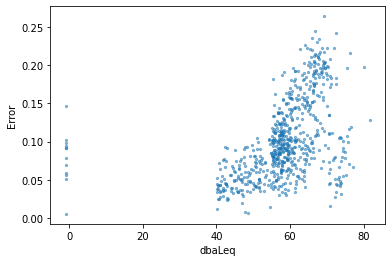

In [6]:
error = np.concatenate([np.abs(p - l).mean(axis=(1, 2)) for p, l in zip(preds_model, labels_model)])
dba = fusa_merged['dbALeq'].values
fig, ax = plt.subplots(figsize=(6, 4), facecolor='w')
ax.scatter(dba, error, s=5, alpha=0.5)
ax.set_xlabel('dbaLeq')
ax.set_ylabel('Error')

../../datasets/AUMILAB/imported/csv_file_61/62ccf8fc7a2acbde063e4ba4.wav


description            Grabación CAPTA desde la estacion Capta 002 Ub...
_id                                             62ccf8fc7a2acbde063e4ba4
date                                                 2022-07-10 05:57:59
dbALeq                                                         40.451053
probability_1_class                                          Music/music
probability_1_value                                                0.238
probability_2_class                                         alerts/siren
probability_2_value                                                0.158
probability_3_class                                    mechanical/others
probability_3_value                                                0.142
Name: 192, dtype: object

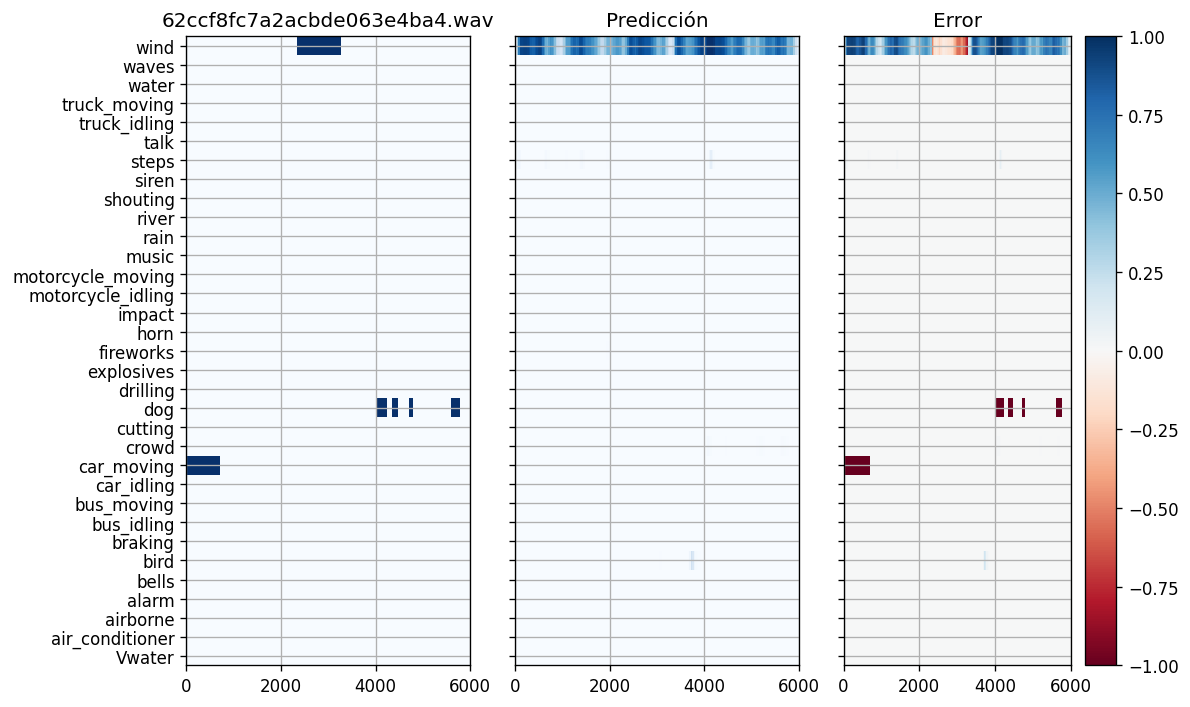

In [7]:
def plot_file_prediction(model: int):
    pred = preds_model[model][0].T
    label = labels_model[model][0].T
    fig, ax = plt.subplots(1, 3, figsize=(10, 6), facecolor='w', dpi=120,
                           tight_layout=True, sharex=True, sharey=True)
    ax[0].pcolormesh(label, cmap=plt.cm.Blues, vmin=0, vmax=1)
    ax[1].pcolormesh(pred, cmap=plt.cm.Blues, vmin=0, vmax=1)
    ax[0].set_title(file_names[model][0])
    ax[1].set_title('Predicción')
    cmap = ax[2].pcolormesh((pred - label), cmap=plt.cm.RdBu, vmin=-1, vmax=1)
    fig.colorbar(cmap)
    ax[2].set_title('Error')
    ax[0].set_yticks(np.arange(0, len(dataset.categories), step=1) + 0.5)
    ax[0].set_yticklabels((dataset.categories));
    ax[0].grid()
    ax[1].grid()
    ax[2].grid()
    print(dataset.file_list[model])
    return dataset.listen(model)
    
idx = fusa_merged['dbALeq'].argmax() # 80 dbaleq
idx = 192 # 40 dbaleq
display(plot_file_prediction(idx))
fusa_merged.loc[idx][["description", "_id", "date", "dbALeq", 
                      "probability_1_class", "probability_1_value",
                      "probability_2_class", "probability_2_value",
                      "probability_3_class", "probability_3_value"]]